In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
#load some data
base_url = "https://raw.githubusercontent.com/NocturneBear/NBA-Data-2010-2024/main/"
files = [
    "regular_season_box_scores_2010_2024_part_1.csv",
    "regular_season_box_scores_2010_2024_part_2.csv",
    "regular_season_box_scores_2010_2024_part_3.csv",
    "play_off_box_scores_2010_2024.csv"
]
dfs = [pd.read_csv(base_url + f) for f in files]

playoffs = dfs[3]
rs1 = dfs[0]
rs2 = dfs[1]
rs3 = dfs[2]

In [ ]:
regular = pd.concat([rs1, rs2, rs3], ignore_index=True)
regular['is_playoff'] = 0
playoffs['is_playoff'] = 1

df = pd.concat([regular, playoffs], ignore_index=True)

#format
df.drop(columns=['jerseyNum', 'comment', 'position', 'matchup'], inplace=True)
df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')

def convert_minutes(min_str):
    try:
        if pd.isna(min_str): return 0
        parts = min_str.split(':')
        return int(parts[0]) + int(parts[1]) / 60 if len(parts) == 2 else 0
    except: return 0

df['minutes_played'] = df['minutes'].apply(convert_minutes)
df.drop(columns=['minutes'], inplace=True)
df['season'] = df['season_year'].str[:4].astype(int)

#data aggs
agg = df.groupby(['personId', 'personName', 'game_date', 'is_playoff']).agg({
    'gameId': 'count',
    'minutes_played': 'sum',
    'points': 'sum',
    'assists': 'sum',
    'reboundsTotal': 'sum',
    'fieldGoalsMade': 'sum',
    'fieldGoalsAttempted': 'sum',
    'threePointersMade': 'sum',
    'freeThrowsMade': 'sum',
    'turnovers': 'sum',
    'plusMinusPoints': 'sum'
}).rename(columns={'gameId': 'games_played'}).reset_index().sort_values('game_date')

agg['ppm'] = (agg['points'] / agg['minutes_played']).dropna()
agg = agg[agg.minutes_played > 0]


# pivoted = agg.pivot_table(index=['personId', 'personName', 'season'], columns='is_playoff',
#                           values=['points', 'minutes_played', 'assists', 'reboundsTotal'], aggfunc='sum')
# pivoted.columns = ['_'.join(map(str, col)) for col in pivoted.columns]
# pivoted = pivoted.dropna()

# #per min stats
# pivoted['ppm_regular'] = pivoted['points_0'] / pivoted['minutes_played_0']
# pivoted['ppm_playoff'] = pivoted['points_1'] / pivoted['minutes_played_1']
# pivoted['residual_ppm'] = pivoted['ppm_playoff'] - pivoted['ppm_regular']


# #resids
# residual_series = pivoted.sort_values(['season', 'personId'])['residual_ppm'].reset_index(drop=True).dropna()

In [5]:
agg

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,...,plusMinusPoints,ppm,TS%,AST/TO,REB%,USG,_roll_TS%,_roll_AST/TO,_roll_REB%,_roll_USG
443297,1630639,A.J. Lawson,2022-11-16,0,1,1.766667,2,0,1,1,...,-5,1.132075,0.999990,0.000000,0.566035,0.566035,0.999990,0.000000,0.566035,0.566035
443302,1630639,A.J. Lawson,2022-12-29,0,1,0.950000,0,0,0,0,...,-4,0.000000,0.000000,0.000000,0.000000,1.052620,0.499995,0.000000,0.283017,0.809328
443305,1630639,A.J. Lawson,2023-01-05,0,1,3.750000,0,0,0,0,...,-6,0.000000,0.000000,0.000000,0.000000,0.266666,0.333330,0.000000,0.188678,0.628440
443306,1630639,A.J. Lawson,2023-01-07,0,1,0.516667,0,0,0,0,...,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.249998,0.000000,0.141509,0.471330
443307,1630639,A.J. Lawson,2023-01-08,0,1,1.916667,0,0,0,0,...,-1,0.000000,0.000000,0.000000,0.000000,0.521736,0.199998,0.000000,0.113207,0.481411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398336,1629597,Zylan Cheatham,2019-11-16,0,1,13.866667,2,1,3,1,...,-17,0.144231,0.333332,0.999990,0.216346,0.288461,0.333332,0.999990,0.216346,0.288461
398337,1629597,Zylan Cheatham,2019-11-17,0,1,5.866667,0,0,0,0,...,-6,0.000000,0.000000,0.000000,0.000000,0.170454,0.166666,0.499995,0.108173,0.229458
398340,1629597,Zylan Cheatham,2020-01-13,0,1,10.950000,2,1,3,1,...,-7,0.182648,0.999990,0.499998,0.273972,0.273972,0.444441,0.499996,0.163439,0.244296
398343,1629597,Zylan Cheatham,2020-08-13,0,1,20.366667,8,1,3,4,...,2,0.392799,0.999998,0.999990,0.147299,0.245499,0.583330,0.624994,0.159404,0.244597


In [6]:
agg['year'] = agg['game_date'].dt.year

In [57]:
from arch import arch_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def create_features(df):
    df = df.copy()
    df['TS%'] = df['points'] / (2 * (df['fieldGoalsAttempted'] + 0.44 * df['freeThrowsMade'] + 1e-5))
    df['AST/TO'] = df['assists'] / (df['turnovers'] + 1e-5)
    df['REB%'] = df['reboundsTotal'] / (df['minutes_played'] + 1e-5)
    df['USG'] = (df['fieldGoalsAttempted'] + 0.44 * df['freeThrowsMade'] + df['turnovers']) / (df['minutes_played'] + 1e-5)
    return df

def rolling_features(df, window=5):
    feats = ['TS%', 'AST/TO', 'REB%', 'USG']
    for f in feats:
        df[f'_roll_{f}'] = df.groupby('personId')[f].transform(lambda x: x.rolling(window, min_periods=1).mean())
    return df

def fit_garchx_oos(player_df, target_col='ppm'):
    """
    1) Use all data with year < 2023 to train the GARCH model.
    2) Produce fitted (predicted) values for the subset with year >= 2023.
    3) Return a DataFrame *only* for the OOS portion, containing predicted diffs.
    """
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LassoCV
    from sklearn.metrics import r2_score
    from arch import arch_model
    
    # ------------------
    # Split into train vs. test (OOS)
    # ------------------
    train_df = player_df.query('year < 2023').copy()
    oos_df   = player_df.query('year >= 2023').copy()
    
    # If not enough training data, bail out
    if len(train_df) < 10:
        return None, None, None, None, None
    
    # ------------------
    # Prepare TRAIN
    # ------------------
    # Drop any rows lacking the target
    train_df = train_df.dropna(subset=[target_col]).copy()

    # Difference the target
    train_df['diff_ppm'] = train_df[target_col].diff()

    # Shift exogenous so we don't leak future info
    feat_cols = [col for col in train_df.columns if col.startswith('_roll_')]
    for c in feat_cols:
        train_df[c] = train_df[c].shift(1)

    # Drop newly introduced NaNs
    train_df.dropna(subset=['diff_ppm'] + feat_cols, inplace=True)
    
    # If still not enough data, stop
    if len(train_df) < 10:
        return None, None, None, None, None

    y_train = train_df['diff_ppm'].values
    X_train = train_df[feat_cols].values
    
    # LASSO for feature selection
    lasso = LassoCV(cv=5).fit(X_train, y_train)
    selected_idx = np.where(lasso.coef_ != 0)[0]
    if len(selected_idx) == 0:
        return None, None, None, None, None
    
    X_train_sel = X_train[:, selected_idx]
    
    # Fit the GARCH(1,1) + ARX(1)
    model = arch_model(
        y_train,
        x=X_train_sel,
        mean='ARX',
        lags=0,
        vol='GARCH',
        p=1, q=1,
        dist='normal'
    )
    res = model.fit(disp='off')
    
    # ------------------
    # In-sample train fitted diffs (just for info)
    # ------------------
    fitted_diff_in = get_in_sample_fitted_values(res, y_train, X_train_sel)
    # We'll compute an in-sample R² on the train portion's differenced data
    from sklearn.metrics import r2_score
    valid_mask = ~pd.isna(fitted_diff_in)
    r2_train = r2_score(y_train[valid_mask], fitted_diff_in[valid_mask]) if np.any(valid_mask) else np.nan
    
    # ------------------
    # Prepare OOS data
    # (Naive: re-difference OOS subset and re-apply the same approach)
    # ------------------
    if len(oos_df) == 0:
        # No OOS data
        return res, lasso, selected_idx, None, r2_train

    # Same differencing & shift for OOS
    oos_df = oos_df.dropna(subset=[target_col]).copy()
    oos_df['diff_ppm'] = oos_df[target_col].diff()
    for c in feat_cols:
        oos_df[c] = oos_df[c].shift(1)
    oos_df.dropna(subset=['diff_ppm'] + feat_cols, inplace=True)
    if len(oos_df) == 0:
        # Means differencing removed all rows
        return res, lasso, selected_idx, None, r2_train

    # Build arrays for the OOS portion
    y_oos = oos_df['diff_ppm'].values
    X_oos = oos_df[feat_cols].values
    X_oos_sel = X_oos[:, selected_idx]

    # ------------------
    # "Predict" OOS diffs
    # ------------------
    # This is a naive approach that uses only the *mean* equation from res.params,
    # ignoring the GARCH recursion on volatility. For a real GARCH forecast,
    # you would typically use res.forecast(..., x=full_exog, last_obs=...).
    #
    # We'll just replicate the "get_in_sample_fitted_values" logic, but feed
    # OOS data to the same ARX parameters. This won't be a true GARCH forecast
    # with updated volatility. See the 'Important Caveat' above.
    #
    fitted_diff_oos = get_out_of_sample_mean_arx(
        res, y_oos, X_oos_sel, y_train[-1]
    )
    oos_df.reset_index(drop=True, inplace=True)
    oos_df['fitted_diff_ppm'] = fitted_diff_oos

    # OOS R² on differenced data
    valid_mask_oos = ~pd.isna(fitted_diff_oos)
    r2_oos = r2_score(oos_df.loc[valid_mask_oos, 'diff_ppm'],
                      oos_df.loc[valid_mask_oos, 'fitted_diff_ppm']) if np.any(valid_mask_oos) else np.nan
    
    return res, lasso, selected_idx, oos_df, r2_oos

def get_in_sample_fitted_values(res, y, X_selected):
    """
    Same as your original: compute the in-sample fitted mean for y_t using:
      y_t = mu + ar.1*y_{t-1} + sum(beta_j * X_{t,j})
    ignoring GARCH volatility.
    """
    import numpy as np
    params = res.params
    mu = params.get('mu', 0.0)
    ar1 = params.get('ar.1', 0.0)

    exog_names = [p for p in params.index if p.startswith('x')]
    exog_coefs = [params[name] for name in exog_names]
    fitted_vals = np.full_like(y, np.nan, dtype=float)
    
    for t in range(1, len(y)):
        mean_t = mu + ar1*y[t-1]
        for j in range(len(exog_coefs)):
            mean_t += exog_coefs[j]*X_selected[t,j]
        fitted_vals[t] = mean_t
    return fitted_vals

def get_out_of_sample_mean_arx(res, y_oos, X_oos_sel, last_y_train):
    """
    Naive approach: For each OOS index t, compute
        yhat(t) = mu + ar.1 * y_{t-1} + sum(beta_j * X_{t,j})
    but y_{t-1} is the *actual or predicted* from the prior step.
    
    We only have the final actual from training for t-1=0.
    Then for subsequent steps, we can EITHER use the newly predicted value
    or remain naive & use the actual y(t-1). If you're fully out-of-sample,
    you typically only have the last actual from the training set, so you
    might do a "recursive" approach. Below, we do a *recursive* approach:
    """
    import numpy as np
    
    params = res.params
    mu = params.get('mu', 0.0)
    ar1 = params.get('ar.1', 0.0)

    exog_names = [p for p in params.index if p.startswith('x')]
    exog_coefs = [params[name] for name in exog_names]

    fitted_vals = np.full_like(y_oos, np.nan, dtype=float)
    
    # We'll keep track of y_{t-1}, starting with the last training observation:
    prev_y = last_y_train
    
    for t in range(len(y_oos)):
        mean_t = mu + ar1 * prev_y
        for j in range(len(exog_coefs)):
            mean_t += exog_coefs[j] * X_oos_sel[t, j]
        fitted_vals[t] = mean_t
        
        # *Recursive* update: assume the actual 'diff' for the next step is the predicted
        # or you might do something else. We'll do "predicted" here:
        prev_y = mean_t  # So next iteration uses predicted diff(t)
    
    return fitted_vals

# -------------------------------------------------------------------
# Example usage in the main loop
# -------------------------------------------------------------------
unique_players = agg.personName.unique()
filtered_out_players = []
player_results = []
all_fitted_results = []

# Preprocessing
agg['game_date'] = pd.to_datetime(agg['game_date'])
agg = agg.sort_values(['personName', 'game_date'])
agg = create_features(agg)
agg = rolling_features(agg)

for player in unique_players:
    sub = agg[agg.personName == player].query('minutes_played > 20')
    if len(sub) < 20:
        filtered_out_players.append(player)
        continue
    
    # Check stationarity (ADF) on level data
    adf_stat, adf_p = adfuller(sub.ppm.dropna())[:2]
    if adf_p > 0.05:
        filtered_out_players.append(player)
        continue
    
    result, lasso, selected, fitted_df, r2_val = fit_garchx_oos(sub)
    if result is None:
        filtered_out_players.append(player)
        continue

    print(f"{player} | ARCH built-in R-squared: {result.rsquared:.3f} | AIC: {result.aic:.2f}")
    print(f"{player} | Manual R² on differenced data: {r2_val:.3f}")
    try:
        fitted_df['personName'] = player
        all_fitted_results.append(fitted_df)
        player_results.append((player, result, r2_val))
    except:
        continue

# Combine all in a single DataFrame (optional)
all_fitted_results_df = pd.concat(all_fitted_results, ignore_index=True)
print(all_fitted_results_df.head(15))


AJ Griffin | ARCH built-in R-squared: 0.297 | AIC: -4.11
AJ Griffin | Manual R² on differenced data: -7.404
Aaron Brooks | ARCH built-in R-squared: 0.002 | AIC: 47.69
Aaron Brooks | Manual R² on differenced data: 0.001
Aaron Gordon | ARCH built-in R-squared: -0.000 | AIC: 66.54
Aaron Gordon | Manual R² on differenced data: -0.000
Aaron Nesmith | ARCH built-in R-squared: -0.005 | AIC: 38.51
Aaron Nesmith | Manual R² on differenced data: -0.006
Aaron Wiggins | ARCH built-in R-squared: 0.033 | AIC: 11.95
Aaron Wiggins | Manual R² on differenced data: -0.071
Adreian Payne | ARCH built-in R-squared: -0.019 | AIC: 10.06
Adreian Payne | Manual R² on differenced data: -0.022
Al Horford | ARCH built-in R-squared: -20742.010 | AIC: 20678.87
Al Horford | Manual R² on differenced data: -44479.446
Al Jefferson | ARCH built-in R-squared: 0.000 | AIC: 70.58
Al Jefferson | Manual R² on differenced data: -0.000
Alex Abrines | ARCH built-in R-squared: -0.002 | AIC: 26.88
Alex Abrines | Manual R² on diff

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Andrew Wiggins | ARCH built-in R-squared: -764.349 | AIC: 6749.35
Andrew Wiggins | Manual R² on differenced data: -2557.819
Anthony Bennett | ARCH built-in R-squared: -0.001 | AIC: 8.54
Anthony Bennett | Manual R² on differenced data: -0.002
Anthony Edwards | ARCH built-in R-squared: 0.001 | AIC: 67.36
Anthony Edwards | Manual R² on differenced data: 0.001
Anthony Morrow | ARCH built-in R-squared: 0.002 | AIC: 47.41
Anthony Morrow | Manual R² on differenced data: 0.000
Anthony Parker | ARCH built-in R-squared: 0.000 | AIC: -28.91
Anthony Parker | Manual R² on differenced data: -0.000
Anthony Randolph | ARCH built-in R-squared: 0.016 | AIC: 6.24
Anthony Randolph | Manual R² on differenced data: 0.011
Anthony Tolliver | ARCH built-in R-squared: -0.000 | AIC: 13.64
Anthony Tolliver | Manual R² on differenced data: -0.000
Antonio McDyess | ARCH built-in R-squared: 0.024 | AIC: -20.69
Antonio McDyess | Manual R² on differenced data: 0.006
Archie Goodwin | ARCH built-in R-squared: 0.020 | AI

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Brook Lopez | ARCH built-in R-squared: -2122472.628 | AIC: 149353272.63
Brook Lopez | Manual R² on differenced data: -3072101.378
Bruno Fernando | ARCH built-in R-squared: 0.091 | AIC: 8.71
Bruno Fernando | Manual R² on differenced data: -0.074
Bryn Forbes | ARCH built-in R-squared: -0.000 | AIC: 31.57
Bryn Forbes | Manual R² on differenced data: 0.000
Buddy Hield | ARCH built-in R-squared: -0.000 | AIC: 28.92
Buddy Hield | Manual R² on differenced data: -0.001
Byron Mullens | ARCH built-in R-squared: 0.002 | AIC: 14.91
Byron Mullens | Manual R² on differenced data: 0.002
CJ McCollum | ARCH built-in R-squared: -0.000 | AIC: 118.40
CJ McCollum | Manual R² on differenced data: -0.002
CJ Miles | ARCH built-in R-squared: 0.001 | AIC: 189.48
CJ Miles | Manual R² on differenced data: -0.002
Cade Cunningham | ARCH built-in R-squared: -0.000 | AIC: 17.74
Cade Cunningham | Manual R² on differenced data: -0.002
Cam Reddish | ARCH built-in R-squared: 0.006 | AIC: 25.98
Cam Reddish | Manual R² on 

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Carmelo Anthony | ARCH built-in R-squared: -22090.352 | AIC: 168508.90
Carmelo Anthony | Manual R² on differenced data: -21898.498
Caron Butler | ARCH built-in R-squared: 0.004 | AIC: 66.82
Caron Butler | Manual R² on differenced data: -0.004
Cartier Martin | ARCH built-in R-squared: 0.016 | AIC: 23.03
Cartier Martin | Manual R² on differenced data: -0.013
Cedi Osman | ARCH built-in R-squared: -0.000 | AIC: 0.62
Cedi Osman | Manual R² on differenced data: 0.000
Chandler Hutchison | ARCH built-in R-squared: 0.133 | AIC: -5.00
Chandler Hutchison | Manual R² on differenced data: -0.035
Chandler Parsons | ARCH built-in R-squared: 0.002 | AIC: -7.35
Chandler Parsons | Manual R² on differenced data: 0.000
Channing Frye | ARCH built-in R-squared: -0.000 | AIC: 15.75
Channing Frye | Manual R² on differenced data: -0.000
Charlie Villanueva | ARCH built-in R-squared: -0.002 | AIC: 32.43
Charlie Villanueva | Manual R² on differenced data: -0.003
Chasson Randle | ARCH built-in R-squared: 0.012 | A

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Daniel Gafford | ARCH built-in R-squared: -0.000 | AIC: 32.90
Daniel Gafford | Manual R² on differenced data: -0.003
Daniel Theis | ARCH built-in R-squared: 0.004 | AIC: 26.83
Daniel Theis | Manual R² on differenced data: -0.010
Danilo Gallinari | ARCH built-in R-squared: 0.001 | AIC: 26.30
Danilo Gallinari | Manual R² on differenced data: -0.035
Danuel House Jr. | ARCH built-in R-squared: 0.002 | AIC: -0.18
Danuel House Jr. | Manual R² on differenced data: 0.001
Dario Saric | ARCH built-in R-squared: -0.000 | AIC: 2.98
Dario Saric | Manual R² on differenced data: -0.003
Darius Garland | ARCH built-in R-squared: -0.007 | AIC: -30.85
Darius Garland | Manual R² on differenced data: -0.034
Darius Miller | ARCH built-in R-squared: 0.002 | AIC: -13.32
Darius Miller | Manual R² on differenced data: -0.002
Darrell Arthur | ARCH built-in R-squared: -0.000 | AIC: 23.18
Darrell Arthur | Manual R² on differenced data: -0.000
David Roddy | ARCH built-in R-squared: 0.142 | AIC: 2.09
David Roddy | M

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Draymond Green | ARCH built-in R-squared: -118566.877 | AIC: 18198.23
Draymond Green | Manual R² on differenced data: -114692.537
Duane Washington Jr. | ARCH built-in R-squared: 0.030 | AIC: 16.95
Duane Washington Jr. | Manual R² on differenced data: -0.081
Duncan Robinson | ARCH built-in R-squared: 0.000 | AIC: 101.85
Duncan Robinson | Manual R² on differenced data: -0.001
Dwayne Bacon | ARCH built-in R-squared: 0.001 | AIC: 8.39
Dwayne Bacon | Manual R² on differenced data: -0.000
Dyson Daniels | ARCH built-in R-squared: 0.125 | AIC: -3.35
Dyson Daniels | Manual R² on differenced data: -0.196
E'Twaun Moore | ARCH built-in R-squared: 0.000 | AIC: 30.32
E'Twaun Moore | Manual R² on differenced data: 0.000
Earl Boykins | ARCH built-in R-squared: 0.016 | AIC: 20.96
Earl Boykins | Manual R² on differenced data: 0.006
Ed Davis | ARCH built-in R-squared: 0.002 | AIC: -80.81
Ed Davis | Manual R² on differenced data: 0.000
Elfrid Payton | ARCH built-in R-squared: 0.000 | AIC: -79.85
Elfrid Pa

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Evan Mobley | ARCH built-in R-squared: 0.002 | AIC: -5.23
Evan Mobley | Manual R² on differenced data: -0.004
Evan Turner | ARCH built-in R-squared: -85575.300 | AIC: 8536.25
Evan Turner | Manual R² on differenced data: -129325.722
Facundo Campazzo | ARCH built-in R-squared: 0.001 | AIC: 2.39
Facundo Campazzo | Manual R² on differenced data: -0.002
Festus Ezeli | ARCH built-in R-squared: 0.024 | AIC: -16.85
Festus Ezeli | Manual R² on differenced data: -0.005
Frank Jackson | ARCH built-in R-squared: 0.002 | AIC: -6.80
Frank Jackson | Manual R² on differenced data: -0.002
Frank Kaminsky | ARCH built-in R-squared: -621314.404 | AIC: 71017.59
Frank Kaminsky | Manual R² on differenced data: -1262512.815
Frank Mason III | ARCH built-in R-squared: -0.017 | AIC: 8.13
Frank Mason III | Manual R² on differenced data: -0.010


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Frank Ntilikina | ARCH built-in R-squared: 0.003 | AIC: -23.44
Frank Ntilikina | Manual R² on differenced data: -0.077
Franz Wagner | ARCH built-in R-squared: -0.003 | AIC: 20.81
Franz Wagner | Manual R² on differenced data: -0.003
Fred VanVleet | ARCH built-in R-squared: -43638977.633 | AIC: 1238567556.75
Fred VanVleet | Manual R² on differenced data: -70047079.967


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Garrett Temple | ARCH built-in R-squared: -5050268.597 | AIC: 4538057.29
Garrett Temple | Manual R² on differenced data: -8189971.640
Garrison Mathews | ARCH built-in R-squared: -0.003 | AIC: 29.24
Garrison Mathews | Manual R² on differenced data: 0.011
Gary Harris | ARCH built-in R-squared: 0.001 | AIC: -124.40
Gary Harris | Manual R² on differenced data: -0.016
Gary Trent Jr. | ARCH built-in R-squared: -0.002 | AIC: 105.60
Gary Trent Jr. | Manual R² on differenced data: -0.005
Gerald Green | ARCH built-in R-squared: 0.006 | AIC: 157.90
Gerald Green | Manual R² on differenced data: 0.004
Gilbert Arenas | ARCH built-in R-squared: 0.003 | AIC: 17.21
Gilbert Arenas | Manual R² on differenced data: 0.001
Glen Davis | ARCH built-in R-squared: 0.002 | AIC: -30.06
Glen Davis | Manual R² on differenced data: -0.001
Glenn Robinson III | ARCH built-in R-squared: 0.000 | AIC: 33.89
Glenn Robinson III | Manual R² on differenced data: -0.000
Gordon Hayward | ARCH built-in R-squared: 0.001 | AIC: 1

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


James Anderson | ARCH built-in R-squared: 0.004 | AIC: 39.08
James Anderson | Manual R² on differenced data: -0.003
James Ennis III | ARCH built-in R-squared: 0.005 | AIC: -43.76
James Ennis III | Manual R² on differenced data: 0.002
James Harden | ARCH built-in R-squared: 0.001 | AIC: 412.46
James Harden | Manual R² on differenced data: 0.003
James Johnson | ARCH built-in R-squared: 0.000 | AIC: 39.28
James Johnson | Manual R² on differenced data: 0.000
James Jones | ARCH built-in R-squared: -0.002 | AIC: 22.51
James Jones | Manual R² on differenced data: -0.001
Jared Sullinger | ARCH built-in R-squared: 0.000 | AIC: 18.47
Jared Sullinger | Manual R² on differenced data: 0.000
Jarell Martin | ARCH built-in R-squared: 0.000 | AIC: -18.53
Jarell Martin | Manual R² on differenced data: 0.003
Jaren Jackson Jr. | ARCH built-in R-squared: -0.001 | AIC: 88.62
Jaren Jackson Jr. | Manual R² on differenced data: 0.000
Jarred Vanderbilt | ARCH built-in R-squared: -0.001 | AIC: -36.17
Jarred Vand

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Jimmy Butler | ARCH built-in R-squared: -13856241.764 | AIC: 4895963.83
Jimmy Butler | Manual R² on differenced data: -17991157.790
Jock Landale | ARCH built-in R-squared: 0.247 | AIC: 9.43
Jock Landale | Manual R² on differenced data: -7.200
Jodie Meeks | ARCH built-in R-squared: -0.000 | AIC: 16.75
Jodie Meeks | Manual R² on differenced data: -0.000


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Joe Ingles | ARCH built-in R-squared: -495404.410 | AIC: 1243411.06
Joe Ingles | Manual R² on differenced data: -806573.009
Joel Anthony | ARCH built-in R-squared: 0.010 | AIC: -103.40
Joel Anthony | Manual R² on differenced data: 0.000
Joel Embiid | ARCH built-in R-squared: 0.002 | AIC: 221.53
Joel Embiid | Manual R² on differenced data: -0.000
John Collins | ARCH built-in R-squared: -0.000 | AIC: 94.18
John Collins | Manual R² on differenced data: -0.000
John Henson | ARCH built-in R-squared: 0.005 | AIC: -41.07
John Henson | Manual R² on differenced data: -0.002
John Jenkins | ARCH built-in R-squared: 0.231 | AIC: -8.47
John Jenkins | Manual R² on differenced data: 0.073
John Konchar | ARCH built-in R-squared: 0.004 | AIC: 10.16
John Konchar | Manual R² on differenced data: 0.008
John Lucas III | ARCH built-in R-squared: 0.055 | AIC: 18.27
John Lucas III | Manual R² on differenced data: -0.142
John Salmons | ARCH built-in R-squared: 0.000 | AIC: -11.67
John Salmons | Manual R² on di

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Jonas Jerebko | ARCH built-in R-squared: -0.002 | AIC: 30.70
Jonas Jerebko | Manual R² on differenced data: 0.000
Jonas Valanciunas | ARCH built-in R-squared: -0.000 | AIC: 118.84
Jonas Valanciunas | Manual R² on differenced data: -0.004
Jonathan Isaac | ARCH built-in R-squared: 0.000 | AIC: 6.14
Jonathan Isaac | Manual R² on differenced data: -0.004
Jonathan Kuminga | ARCH built-in R-squared: 0.026 | AIC: -0.85
Jonathan Kuminga | Manual R² on differenced data: -0.051
Jonathon Simmons | ARCH built-in R-squared: 0.006 | AIC: 36.13
Jonathon Simmons | Manual R² on differenced data: 0.002
Jordan Bell | ARCH built-in R-squared: 0.005 | AIC: 12.87
Jordan Bell | Manual R² on differenced data: 0.000
Jordan Hamilton | ARCH built-in R-squared: 0.007 | AIC: 6.55
Jordan Hamilton | Manual R² on differenced data: 0.013
Jordan Hill | ARCH built-in R-squared: -0.000 | AIC: 13.88
Jordan Hill | Manual R² on differenced data: -0.000
Jordan McLaughlin | ARCH built-in R-squared: -0.004 | AIC: 1.09
Jordan M

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Kelly Olynyk | ARCH built-in R-squared: 0.001 | AIC: 113.35
Kelly Olynyk | Manual R² on differenced data: -0.012
Kelly Oubre Jr. | ARCH built-in R-squared: -0.000 | AIC: 11.65
Kelly Oubre Jr. | Manual R² on differenced data: 0.001
Kemba Walker | ARCH built-in R-squared: -22358497229.028 | AIC: 201855948821.98
Kemba Walker | Manual R² on differenced data: -22107117396.403
Kendall Marshall | ARCH built-in R-squared: 0.019 | AIC: 4.50
Kendall Marshall | Manual R² on differenced data: 0.017
Kendrick Perkins | ARCH built-in R-squared: -7457.942 | AIC: 3848.99
Kendrick Perkins | Manual R² on differenced data: -755.859
Kenneth Faried | ARCH built-in R-squared: -0.000 | AIC: 66.18
Kenneth Faried | Manual R² on differenced data: 0.000
Kent Bazemore | ARCH built-in R-squared: -0.000 | AIC: 97.17
Kent Bazemore | Manual R² on differenced data: -0.000


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Kenyon Martin Jr. | ARCH built-in R-squared: -13560128.091 | AIC: 5820767.06
Kenyon Martin Jr. | Manual R² on differenced data: -6469110.361
Keon Johnson | ARCH built-in R-squared: 0.127 | AIC: 2.09
Keon Johnson | Manual R² on differenced data: -1.017
Kessler Edwards | ARCH built-in R-squared: 0.083 | AIC: 3.40
Kessler Edwards | Manual R² on differenced data: -1.945
Kevin Love | ARCH built-in R-squared: -0.000 | AIC: 167.64
Kevin Love | Manual R² on differenced data: 0.002
Kevin Porter Jr. | ARCH built-in R-squared: 0.002 | AIC: 30.70
Kevin Porter Jr. | Manual R² on differenced data: -0.002
Keyon Dooling | ARCH built-in R-squared: 0.004 | AIC: -5.24
Keyon Dooling | Manual R² on differenced data: 0.006
Khem Birch | ARCH built-in R-squared: 0.000 | AIC: -61.05
Khem Birch | Manual R² on differenced data: -0.000
Khris Middleton | ARCH built-in R-squared: 0.001 | AIC: 40.75
Khris Middleton | Manual R² on differenced data: -0.008
Killian Hayes | ARCH built-in R-squared: 0.001 | AIC: -27.10
K

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Linas Kleiza | ARCH built-in R-squared: 0.020 | AIC: 35.22
Linas Kleiza | Manual R² on differenced data: 0.004
Lonnie Walker IV | ARCH built-in R-squared: -0.000 | AIC: 30.94
Lonnie Walker IV | Manual R² on differenced data: -0.001
Lou Williams | ARCH built-in R-squared: -705424436.722 | AIC: 6081721.61
Lou Williams | Manual R² on differenced data: -630678848.418
Lucas Nogueira | ARCH built-in R-squared: -0.010 | AIC: -12.51
Lucas Nogueira | Manual R² on differenced data: -0.042
Luis Scola | ARCH built-in R-squared: -0.001 | AIC: 72.36
Luis Scola | Manual R² on differenced data: -0.001
Luka Doncic | ARCH built-in R-squared: 0.001 | AIC: 115.09
Luka Doncic | Manual R² on differenced data: 0.003
Luke Babbitt | ARCH built-in R-squared: 0.004 | AIC: -20.45
Luke Babbitt | Manual R² on differenced data: 0.002
Luke Kornet | ARCH built-in R-squared: 0.029 | AIC: 21.31
Luke Kornet | Manual R² on differenced data: -0.583
Luke Ridnour | ARCH built-in R-squared: 0.006 | AIC: -76.84
Luke Ridnour | 

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Marcus Morris Sr. | ARCH built-in R-squared: -8828335.560 | AIC: 204209373.97
Marcus Morris Sr. | Manual R² on differenced data: -16697599.865
Marcus Smart | ARCH built-in R-squared: 0.000 | AIC: -11.05
Marcus Smart | Manual R² on differenced data: -0.002
Marcus Thornton | ARCH built-in R-squared: 0.001 | AIC: 107.73
Marcus Thornton | Manual R² on differenced data: -0.000
Markel Brown | ARCH built-in R-squared: 0.019 | AIC: 0.82
Markel Brown | Manual R² on differenced data: -0.006
Markelle Fultz | ARCH built-in R-squared: 0.002 | AIC: 11.91
Markelle Fultz | Manual R² on differenced data: -0.003
Marquese Chriss | ARCH built-in R-squared: 0.008 | AIC: 35.85
Marquese Chriss | Manual R² on differenced data: 0.004
Martell Webster | ARCH built-in R-squared: 0.000 | AIC: -69.17
Martell Webster | Manual R² on differenced data: 0.000
Marvin Bagley III | ARCH built-in R-squared: -0.000 | AIC: -18.70
Marvin Bagley III | Manual R² on differenced data: 0.001
Marvin Williams | ARCH built-in R-square

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Matthew Dellavedova | ARCH built-in R-squared: -3292491998.732 | AIC: 7562120632.62
Matthew Dellavedova | Manual R² on differenced data: -3298695203.363
Maurice Harkless | ARCH built-in R-squared: 0.001 | AIC: -23.67
Maurice Harkless | Manual R² on differenced data: -0.002
Max Strus | ARCH built-in R-squared: 0.003 | AIC: 48.43
Max Strus | Manual R² on differenced data: -0.035
Maxi Kleber | ARCH built-in R-squared: 0.002 | AIC: 17.22
Maxi Kleber | Manual R² on differenced data: -0.001
Metta World Peace | ARCH built-in R-squared: 0.000 | AIC: -75.10
Metta World Peace | Manual R² on differenced data: 0.000
Meyers Leonard | ARCH built-in R-squared: -0.027 | AIC: -36.27
Meyers Leonard | Manual R² on differenced data: nan


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Michael Carter-Williams | ARCH built-in R-squared: -9178993.559 | AIC: 78955361.59
Michael Carter-Williams | Manual R² on differenced data: -9197891.818
Michael Porter Jr. | ARCH built-in R-squared: -0.002 | AIC: 41.71
Michael Porter Jr. | Manual R² on differenced data: -0.001
Mickael Pietrus | ARCH built-in R-squared: 0.019 | AIC: 17.09
Mickael Pietrus | Manual R² on differenced data: 0.007


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Mike Conley | ARCH built-in R-squared: -9413.826 | AIC: 2707616.63
Mike Conley | Manual R² on differenced data: -23478.072
Mike Dunleavy | ARCH built-in R-squared: -0.001 | AIC: 20.80
Mike Dunleavy | Manual R² on differenced data: -0.001
Mike James | ARCH built-in R-squared: 0.002 | AIC: 13.41
Mike James | Manual R² on differenced data: 0.002
Mike Miller | ARCH built-in R-squared: -0.002 | AIC: 42.08
Mike Miller | Manual R² on differenced data: -0.002
Mike Muscala | ARCH built-in R-squared: -0.000 | AIC: 69.61
Mike Muscala | Manual R² on differenced data: -0.000
Miles Bridges | ARCH built-in R-squared: -0.000 | AIC: 24.03
Miles Bridges | Manual R² on differenced data: -0.003
Miles McBride | ARCH built-in R-squared: 0.085 | AIC: 4.54
Miles McBride | Manual R² on differenced data: -0.133
Mirza Teletovic | ARCH built-in R-squared: -0.000 | AIC: 89.27
Mirza Teletovic | Manual R² on differenced data: -0.000
Mo Bamba | ARCH built-in R-squared: -0.011 | AIC: 17.69
Mo Bamba | Manual R² on diff

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Naz Reid | ARCH built-in R-squared: 0.019 | AIC: 8.51
Naz Reid | Manual R² on differenced data: -0.054
Nazr Mohammed | ARCH built-in R-squared: -0.003 | AIC: 0.75
Nazr Mohammed | Manual R² on differenced data: -0.010
Nick Calathes | ARCH built-in R-squared: -0.099 | AIC: -4.83
Nick Calathes | Manual R² on differenced data: -0.060
Nick Collison | ARCH built-in R-squared: -0.002 | AIC: -56.97
Nick Collison | Manual R² on differenced data: -0.001
Nick Richards | ARCH built-in R-squared: -0.011 | AIC: 15.00
Nick Richards | Manual R² on differenced data: -0.014
Nick Young | ARCH built-in R-squared: 0.000 | AIC: 141.63
Nick Young | Manual R² on differenced data: -0.001
Nickeil Alexander-Walker | ARCH built-in R-squared: 0.006 | AIC: 40.16
Nickeil Alexander-Walker | Manual R² on differenced data: -0.020


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Nicolas Batum | ARCH built-in R-squared: -1561113961.489 | AIC: 552576108.56
Nicolas Batum | Manual R² on differenced data: -2688913215.783
Nikola Jokic | ARCH built-in R-squared: -0.000 | AIC: 169.38
Nikola Jokic | Manual R² on differenced data: 0.004
Nikola Mirotic | ARCH built-in R-squared: 0.000 | AIC: 118.83
Nikola Mirotic | Manual R² on differenced data: -0.000
Nikola Pekovic | ARCH built-in R-squared: 0.002 | AIC: -14.94
Nikola Pekovic | Manual R² on differenced data: 0.002
Noah Vonleh | ARCH built-in R-squared: -0.002 | AIC: -52.41
Noah Vonleh | Manual R² on differenced data: -0.002
Norman Powell | ARCH built-in R-squared: 0.002 | AIC: 72.43
Norman Powell | Manual R² on differenced data: -0.005
O.J. Mayo | ARCH built-in R-squared: 0.001 | AIC: 13.32
O.J. Mayo | Manual R² on differenced data: 0.001
Obi Toppin | ARCH built-in R-squared: 0.022 | AIC: 10.83
Obi Toppin | Manual R² on differenced data: -0.017
Omari Spellman | ARCH built-in R-squared: 0.110 | AIC: 16.78
Omari Spellman

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Robert Covington | ARCH built-in R-squared: -38973.570 | AIC: 297198.03
Robert Covington | Manual R² on differenced data: -58576.842
Rodney McGruder | ARCH built-in R-squared: -0.000 | AIC: 6.06
Rodney McGruder | Manual R² on differenced data: -0.048
Rodney Stuckey | ARCH built-in R-squared: -622891.960 | AIC: 235619381.98
Rodney Stuckey | Manual R² on differenced data: -496706.978
Rodrigue Beaubois | ARCH built-in R-squared: -0.000 | AIC: 17.29
Rodrigue Beaubois | Manual R² on differenced data: -0.001
Romeo Langford | ARCH built-in R-squared: 0.003 | AIC: 7.37
Romeo Langford | Manual R² on differenced data: -0.071


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Rondae Hollis-Jefferson | ARCH built-in R-squared: 0.010 | AIC: -6.05
Rondae Hollis-Jefferson | Manual R² on differenced data: 0.006
Ronnie Price | ARCH built-in R-squared: 0.001 | AIC: -0.68
Ronnie Price | Manual R² on differenced data: 0.002
Ronny Turiaf | ARCH built-in R-squared: 0.000 | AIC: -11.73
Ronny Turiaf | Manual R² on differenced data: -0.000
Roy Hibbert | ARCH built-in R-squared: 0.055 | AIC: -62.80
Roy Hibbert | Manual R² on differenced data: -2.071
Rudy Gay | ARCH built-in R-squared: 0.001 | AIC: -10.83
Rudy Gay | Manual R² on differenced data: -0.000
Rudy Gobert | ARCH built-in R-squared: 0.000 | AIC: -234.59
Rudy Gobert | Manual R² on differenced data: -0.000
Rui Hachimura | ARCH built-in R-squared: -0.000 | AIC: 17.39
Rui Hachimura | Manual R² on differenced data: 0.001
Ryan Hollins | ARCH built-in R-squared: 0.020 | AIC: 6.89
Ryan Hollins | Manual R² on differenced data: 0.012
Saddiq Bey | ARCH built-in R-squared: 0.007 | AIC: 91.69
Saddiq Bey | Manual R² on differen

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Solomon Hill | ARCH built-in R-squared: -1.522 | AIC: 347.66
Solomon Hill | Manual R² on differenced data: -1.446
Sonny Weems | ARCH built-in R-squared: -0.005 | AIC: 2.23
Sonny Weems | Manual R² on differenced data: -0.007
Spencer Hawes | ARCH built-in R-squared: 0.005 | AIC: -40.85
Spencer Hawes | Manual R² on differenced data: 0.001
Stanley Johnson | ARCH built-in R-squared: 0.001 | AIC: 24.94
Stanley Johnson | Manual R² on differenced data: 0.021


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stephen Curry | ARCH built-in R-squared: -2026277.471 | AIC: 54125366.33
Stephen Curry | Manual R² on differenced data: -779152.192
Steve Nash | ARCH built-in R-squared: -2614189.311 | AIC: 66308.58
Steve Nash | Manual R² on differenced data: -2277172.361
Steve Novak | ARCH built-in R-squared: 0.016 | AIC: 39.14
Steve Novak | Manual R² on differenced data: 0.002
Svi Mykhailiuk | ARCH built-in R-squared: 0.005 | AIC: -7.58
Svi Mykhailiuk | Manual R² on differenced data: 0.011
T.J. McConnell | ARCH built-in R-squared: -0.000 | AIC: -86.05
T.J. McConnell | Manual R² on differenced data: 0.001
Taj Gibson | ARCH built-in R-squared: 0.002 | AIC: -220.26
Taj Gibson | Manual R² on differenced data: nan
Talen Horton-Tucker | ARCH built-in R-squared: 0.009 | AIC: 49.37
Talen Horton-Tucker | Manual R² on differenced data: 0.008
Taurean Prince | ARCH built-in R-squared: 0.001 | AIC: 64.00
Taurean Prince | Manual R² on differenced data: -0.000
Terrence Ross | ARCH built-in R-squared: 0.000 | AIC: 2

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Tyrone Wallace | ARCH built-in R-squared: 0.060 | AIC: -2.26
Tyrone Wallace | Manual R² on differenced data: 0.047
Tyus Jones | ARCH built-in R-squared: -6550750875.174 | AIC: 2094429305.75
Tyus Jones | Manual R² on differenced data: -11104650640.027


/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Udonis Haslem | ARCH built-in R-squared: 0.001 | AIC: -46.81
Udonis Haslem | Manual R² on differenced data: 0.000
Vit Krejci | ARCH built-in R-squared: 0.001 | AIC: 5.20
Vit Krejci | Manual R² on differenced data: 0.005
Vladimir Radmanovic | ARCH built-in R-squared: 0.036 | AIC: 3.04
Vladimir Radmanovic | Manual R² on differenced data: -0.038
Walker Kessler | ARCH built-in R-squared: -0.034 | AIC: 0.91
Walker Kessler | Manual R² on differenced data: -0.021
Wayne Selden | ARCH built-in R-squared: 0.001 | AIC: 36.48
Wayne Selden | Manual R² on differenced data: 0.002
Willie Cauley-Stein | ARCH built-in R-squared: -0.000 | AIC: -45.17
Willie Cauley-Stein | Manual R² on differenced data: -0.000
Willie Green | ARCH built-in R-squared: 0.028 | AIC: -7.66
Willie Green | Manual R² on differenced data: 0.009
Wilson Chandler | ARCH built-in R-squared: -0.000 | AIC: 14.97
Wilson Chandler | Manual R² on differenced data: -0.000
Xavier Henry | ARCH built-in R-squared: 0.004 | AIC: 34.64
Xavier Henr

/opt/homebrew/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Zaza Pachulia | ARCH built-in R-squared: -6613.466 | AIC: 3955.42
Zaza Pachulia | Manual R² on differenced data: -7623.941
Zeke Nnaji | ARCH built-in R-squared: 0.301 | AIC: 8.04
Zeke Nnaji | Manual R² on differenced data: -1.050
    personId    personName  game_date  is_playoff  games_played  \
0    1631100    AJ Griffin 2023-01-16           0             1   
1    1631100    AJ Griffin 2023-01-18           0             1   
2    1631100    AJ Griffin 2023-01-21           0             1   
3    1631100    AJ Griffin 2023-01-23           0             1   
4    1631100    AJ Griffin 2023-01-25           0             1   
5    1631100    AJ Griffin 2023-01-30           0             1   
6    1631100    AJ Griffin 2023-02-04           0             1   
7    1631100    AJ Griffin 2023-03-17           0             1   
8    1631100    AJ Griffin 2023-03-25           0             1   
9    1631100    AJ Griffin 2023-04-04           0             1   
10   1631100    AJ Griffin 2023-0

In [58]:
def reconstruct_predicted_ppm_actual(df_group):
    """
    For each row t, set predicted_ppm[t] = actual ppm[t-1] + fitted_diff_ppm[t].
    The first row uses its own actual ppm (since there's no 't-1' for the first row).
    """
    df_group = df_group.sort_values('game_date').copy()
    
    # We will store predicted ppm in this list:
    predicted = []
    
    for i in range(len(df_group)):
        if i == 0:
            # For the first row, there's no t-1. Use the actual ppm as "predicted."
            predicted.append(df_group.iloc[i]['ppm'])
        else:
            # For row i, add fitted diff[i] to the *actual* ppm of row i-1
            actual_prev_ppm = df_group.iloc[i - 10 : i-1]['ppm'].mean()
            # actual_prev_ppm = df_group.iloc[i - 1]['ppm']
            fitted_diff     = df_group.iloc[i]['fitted_diff_ppm'].clip(-0.1, 0.1)
            predicted.append(max(actual_prev_ppm + 0, 0))
    
    df_group['predicted_ppm'] = predicted
    return df_group

# Example usage:
predicted_df = (
    all_fitted_results_df
    .groupby('personName', group_keys=False)
    .apply(reconstruct_predicted_ppm_actual)
)

# Now predicted_df has a new column: 'predicted_ppm'
print(predicted_df[['personName', 'game_date', 'ppm', 
                    'fitted_diff_ppm', 'predicted_ppm']].head(15))


      personName  game_date       ppm  fitted_diff_ppm  predicted_ppm
0     AJ Griffin 2023-01-16  0.592105    -1.451036e-01       0.592105
1     AJ Griffin 2023-01-18  0.446097    -4.353094e-01            NaN
2     AJ Griffin 2023-01-21  0.554371    -4.353094e-01            NaN
3     AJ Griffin 2023-01-23  0.358306    -7.255145e-01            NaN
4     AJ Griffin 2023-01-25  0.387931    -1.015720e+00            NaN
5     AJ Griffin 2023-01-30  0.612726    -7.255188e-01            NaN
6     AJ Griffin 2023-02-04  0.576553    -7.255188e-01            NaN
7     AJ Griffin 2023-03-17  0.576000    -8.706087e-06            NaN
8     AJ Griffin 2023-03-25  0.471429    -2.902072e-01            NaN
9     AJ Griffin 2023-04-04  0.282258    -2.902116e-01            NaN
10    AJ Griffin 2023-04-05  0.706922    -1.451106e-01       0.508391
11    AJ Griffin 2023-04-09  0.443182    -2.902092e-01       0.473963
12  Aaron Gordon 2023-01-02  0.359102    -6.326831e-10       0.359102
13  Aaron Gordon 202

<Axes: xlabel='predicted_ppm', ylabel='ppm'>

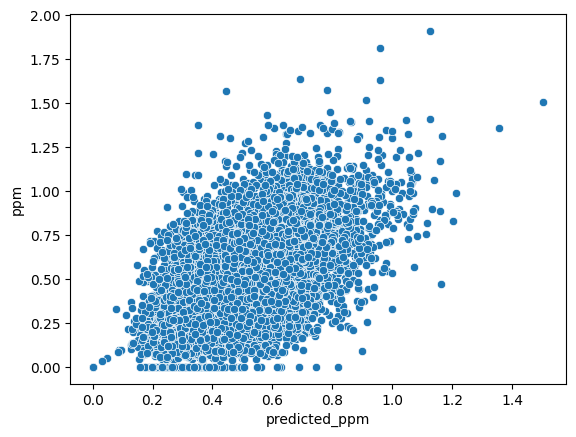

In [59]:
sns.scatterplot(predicted_df, x = 'predicted_ppm', y = 'ppm')

In [60]:
temp = all_fitted_results_df.assign(diff_clipped = lambda x:x.fitted_diff_ppm.clip(-0.1,0.1))

<Axes: xlabel='diff_clipped', ylabel='diff_ppm'>

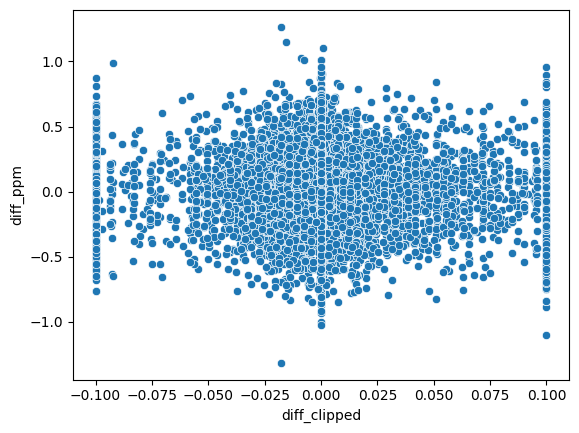

In [61]:
sns.scatterplot(temp, x = 'diff_clipped', y = 'diff_ppm')

In [62]:
temp[['diff_ppm', 'diff_clipped']].corr()

,diff_ppm,diff_clipped
diff_ppm,1.000000,-0.003757
diff_clipped,-0.003757,1.000000


In [63]:
predicted_df[['predicted_ppm', 'ppm']].corr()

,predicted_ppm,ppm
predicted_ppm,1.000000,0.544127
ppm,0.544127,1.000000


In [64]:
pred_dropped = predicted_df.dropna()

In [45]:
r2_score(pred_dropped.ppm, pred_dropped.predicted_ppm)

0.2804307447887576